## Required additional feedforward weight to compensate for fewer neurons
Comparable to linear rate model

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_3b_requiredFFweight_nocompetition import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', **{'family': 'serif', 'size': 20})
mpl.rcParams.update({'font.size': 20})
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage import measure

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Scan parameter range

In [2]:
fname_res = 'data/3b_r_twoseqs.pckl'
t = params['t']


In [3]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_res)
    
else:

    r = np.zeros([
        len(params['range_nE1']),
        len(params['range_pot_ff1']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, nE_1 in enumerate(tqdm(params['range_nE1'])):
        for j, pot_ff_1 in enumerate(params['range_pot_ff1']):
            sim = sim_wc.Simulator(params)
            nE = params['nE']
            nI = params['nI']
            sim.p['nE'][1] = nE_1
            sim.p['nI'][1] = int(nE_1*0.25)
            pot_ff = params['pot_ff']
            sim.p['pot_ff'][1] = pot_ff_1
            sim.set_interaction_matrix()
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
    tools_wc.save_pckl(r, fname_res)

In [4]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_nE1']),
    len(params['range_pot_ff1']),
    len(params['seqs'])
], dtype=bool)
cond = np.zeros([
    len(params['range_nE1']),
    len(params['range_pot_ff1']),
    len(params['seqs']),
    4], dtype=bool)
mean_t_act = np.zeros([
    len(params['range_nE1']),
    len(params['range_pot_ff1']),
    len(params['seqs'])])
    

dt = np.mean(np.unique(np.diff(params['t'])))

for i, nE_i in enumerate(params['range_nE1']):
    for j, _ in enumerate(params['range_pot_ff1']):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            (crit[i, j, m],
             cond[i, j, m, 0],
             cond[i, j, m, 1],
             cond[i, j, m, 2],
             cond[i, j, m, 3]) = tools_wc.peak_criterium(
                rE_ijm, params['r_min'],
                seq_m_pos, params['tol'],
                return_conds=True)
            mean_t_act[i, j, m] = tools_wc.mean_activation_time(
                rE_ijm, params['r_min'], dt)

### Create linear approximation

### Load results from 3a

In [5]:
crit_comp = tools_wc.load_pckl('data/3a_r_twoseqs_crit')
#linapprox_comp = tools_wc.load_pckl('data/3a_r_twoseqs_linapprox')

### Plot

In [6]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2., 3.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

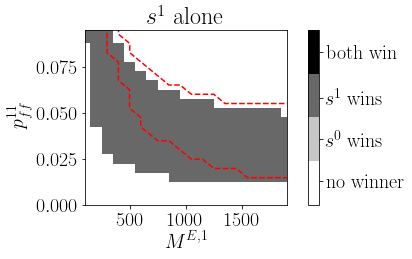

In [10]:
piv = np.sum(crit, axis=2)
f = 0.1
piv = piv - f*crit[:, :, 0]
piv = piv + f*crit[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(6,4))


# adjust xticks to represent sum of nE and nI
rng_nE1 = params['range_nE1'] 
xticks = rng_nE1
yticks = params['p_ff']*params['range_pot_ff1']
#a[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(xticks, yticks, piv.T, cmap=cmap, norm=norm)


ax[0,0].set_title('$s^1$ alone', fontsize=24)
ax[0,0].set_xlabel('$M^{E,1}$')
ax[0,0].set_ylabel('$p^{11}_{ff}$')

y_range = params['p_ff']*params['range_pot_ff1']
ax[0,0].set_ylim(y_range[0], y_range[-1])
ax[0,0].set_xlim(params['range_nE1'][0], params['range_nE1'][-1])

ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    ticks=[0.5, 1., 1.5, 2.5],
    boundaries=bounds[:-1], format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ wins',
     'both win'])


# insert linear approximation
#if p__11_ff_lin_nocomp:
#    ax[0,0].plot(params['range_nE1'], p__11_ff_lin_nocomp, c='orange')
#    ax[0,0].plot(linapprox_comp[:, 0], linapprox_comp[:, 1], c='red')

# insert simulation results of 3a
xticks_shifted = xticks + np.mean(np.diff(xticks))/2.  # shift x and y ticks to match outer boundaries
yticks = yticks + np.mean(np.diff(yticks))/2.

ax[0, 0].contour(
    xticks+50,
    params['p_ff']*params['range_pot_ff1']+0.0025,
    crit_comp[:,:,1].T,
    colors='red', 
    levels=[0.49],
    linestyles='dashed')
    
fig.tight_layout()

fig.savefig('figures/3b_FFweightScalesNonlinearly_nocomp.svg')